In [1]:
] activate .

[Vandermonde matrix:](https://en.wikipedia.org/wiki/Vandermonde_matrix)
\begin{align}V=\begin{bmatrix}1&\alpha _{1}&\alpha _{1}^{2}&\dots &\alpha _{1}^{n-1}\\1&\alpha _{2}&\alpha _{2}^{2}&\dots &\alpha _{2}^{n-1}\\1&\alpha _{3}&\alpha _{3}^{2}&\dots &\alpha _{3}^{n-1}\\\vdots &\vdots &\vdots &\ddots &\vdots \\1&\alpha _{m}&\alpha _{m}^{2}&\dots &\alpha _{m}^{n-1}\end{bmatrix}\end{align}

In [2]:
using PyCall

In [3]:
np = pyimport("numpy")

PyObject <module 'numpy' from 'C:\\Users\\carsten\\Anaconda3\\lib\\site-packages\\numpy\\__init__.py'>

In [4]:
np.vander(1:5, increasing=true)

5×5 Array{Int32,2}:
 1  1   1    1    1
 1  2   4    8   16
 1  3   9   27   81
 1  4  16   64  256
 1  5  25  125  625

The source code for this function is [here](https://github.com/numpy/numpy/blob/v1.16.1/numpy/lib/twodim_base.py#L475-L563). It calls `np.multiply.accumulate` which is implemented in C [here](https://github.com/numpy/numpy/blob/deea4983aedfa96905bbaee64e3d1de84144303f/numpy/core/src/umath/ufunc_object.c#L3678). However, this code doesn't actually perform the computation, it basically only checks types and stuff. The actual kernel that gets called is [here](https://github.com/numpy/numpy/blob/deea4983aedfa96905bbaee64e3d1de84144303f/numpy/core/src/umath/loops.c.src#L1742). This isn't even C code but a template for C code which is used to generate type specific kernels.

Overall, this setup only supports a limited set of types, like `Float64`, `Float32`, and so forth.

Here is a simple Julia implementation (taken from [Steve's Julia intro](https://web.mit.edu/18.06/www/Fall17/1806/julia/Julia-intro.pdf))

In [5]:
function vander(x::AbstractVector{T},  n=length(x)) where T
    m = length(x)
    V = Matrix{T}(undef, m, n)
    for j = 1:m
        V[j,1] = one(x[j])
    end
    for i= 2:n
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

vander (generic function with 2 methods)

In [6]:
vander(1:5)

5×5 Array{Int64,2}:
 1  1   1    1    1
 1  2   4    8   16
 1  3   9   27   81
 1  4  16   64  256
 1  5  25  125  625

# A quick benchmark

In [7]:
using BenchmarkTools, Plots

In [25]:
ns = exp10.(range(1, 4, length=30));

In [26]:
tnp = Float64[]
tjl = Float64[]
for n in ns
    x = 1:n |> collect
    push!(tnp, @belapsed np.vander($x) samples=3 evals=1)
    push!(tjl, @belapsed vander($x) samples=3 evals=1)
end    

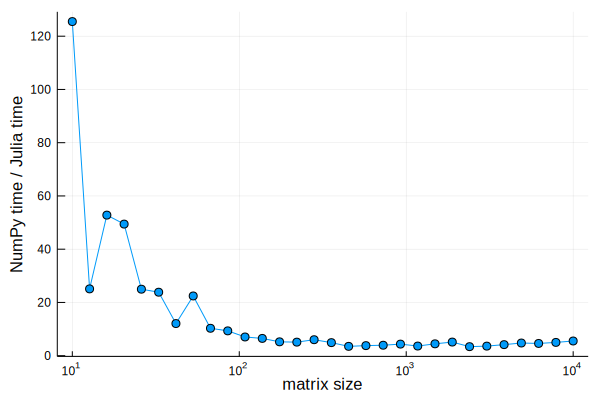

In [43]:
plot(ns, tnp./tjl, m=:circle, xscale=:log10, xlab="matrix size", ylab="NumPy time / Julia time", legend=:false)

In [44]:
savefig("vandermonde.pdf")

Note that the clean and concise Julia implementation is beating the numpy implementation for small and is on-par for large matrix sizes!

At the same time, the Julia code is generic and works for arbitrary types!

In [52]:
vander(Int32[4, 8, 16, 32])

4×4 Array{Int32,2}:
 1   4    16     64
 1   8    64    512
 1  16   256   4096
 1  32  1024  32768

In [47]:
vander(["this", "is", "a", "test"])

4×4 Array{String,2}:
 ""  "this"  "thisthis"  "thisthisthis"
 ""  "is"    "isis"      "isisis"      
 ""  "a"     "aa"        "aaa"         
 ""  "test"  "testtest"  "testtesttest"

In [48]:
vander([true, false, false, true])

4×4 Array{Bool,2}:
 true   true   true   true
 true  false  false  false
 true  false  false  false
 true   true   true   true